Setup the Keras Environment

In [13]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt

Construct the Encoder

In [2]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 16)                50192     
                                                                 
 z (Dense)                   (None, 3)                 51        
                                                                 
Total params: 69059 (269.76 KB)
Trainable params: 69059 (2

Construct the Decoder

In [3]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 6272)              25088     
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        73792     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

Define the AE as a Class with Custom Training

In [4]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
        }

Train the Model

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digit_labels = np.concatenate([y_train, y_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

ae = AE(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam())
history = ae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 87s 141ms/step - loss: 238.6958 - reconstruction_loss: 186.7674
Epoch 2/30
547/547 [==============================] - 73s 133ms/step - loss: 146.1867 - reconstruction_loss: 143.7158
Epoch 3/30
547/547 [==============================] - 104s 189ms/step - loss: 139.2113 - reconstruction_loss: 138.4460
Epoch 4/30
547/547 [==============================] - 123s 224ms/step - loss: 136.1944 - reconstruction_loss: 135.5981
Epoch 5/30
547/547 [==============================] - 98s 179ms/step - loss: 133.7445 - reconstruction_loss: 133.5350
Epoch 6/30
547/547 [==============================] - 97s 176ms/step - loss: 132.1109 - reconstruction_loss: 132.0325
Epoch 7/30
547/547 [==============================] - 99s 181ms/step - loss: 130.9950 - reconstruction_loss: 130.8666
Epoch 8/30
547/547 [==============================] - 98s 179ms/step - loss: 129.9082 - reconstruction_loss: 129.8656
Epoch 9/30
547/547 [==============================] - 

In [6]:
print(history.history.keys())

dict_keys(['loss', 'reconstruction_loss'])


Plot the loss function

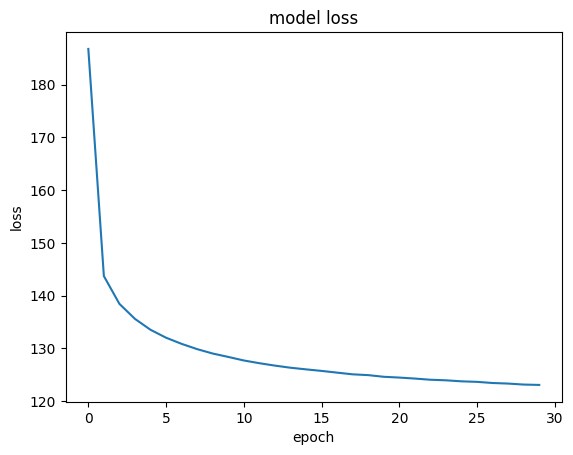

In [7]:
# summarize history for accuracy
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


Save the Model Weights

In [8]:
ae.save_weights('./P1E2_AE_mnist_latent2.weights.h5')

Display how the latent space clusters different digit classes

C:\Users\HP\AppData\Local\Temp\ipykernel_17736\2823785926.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


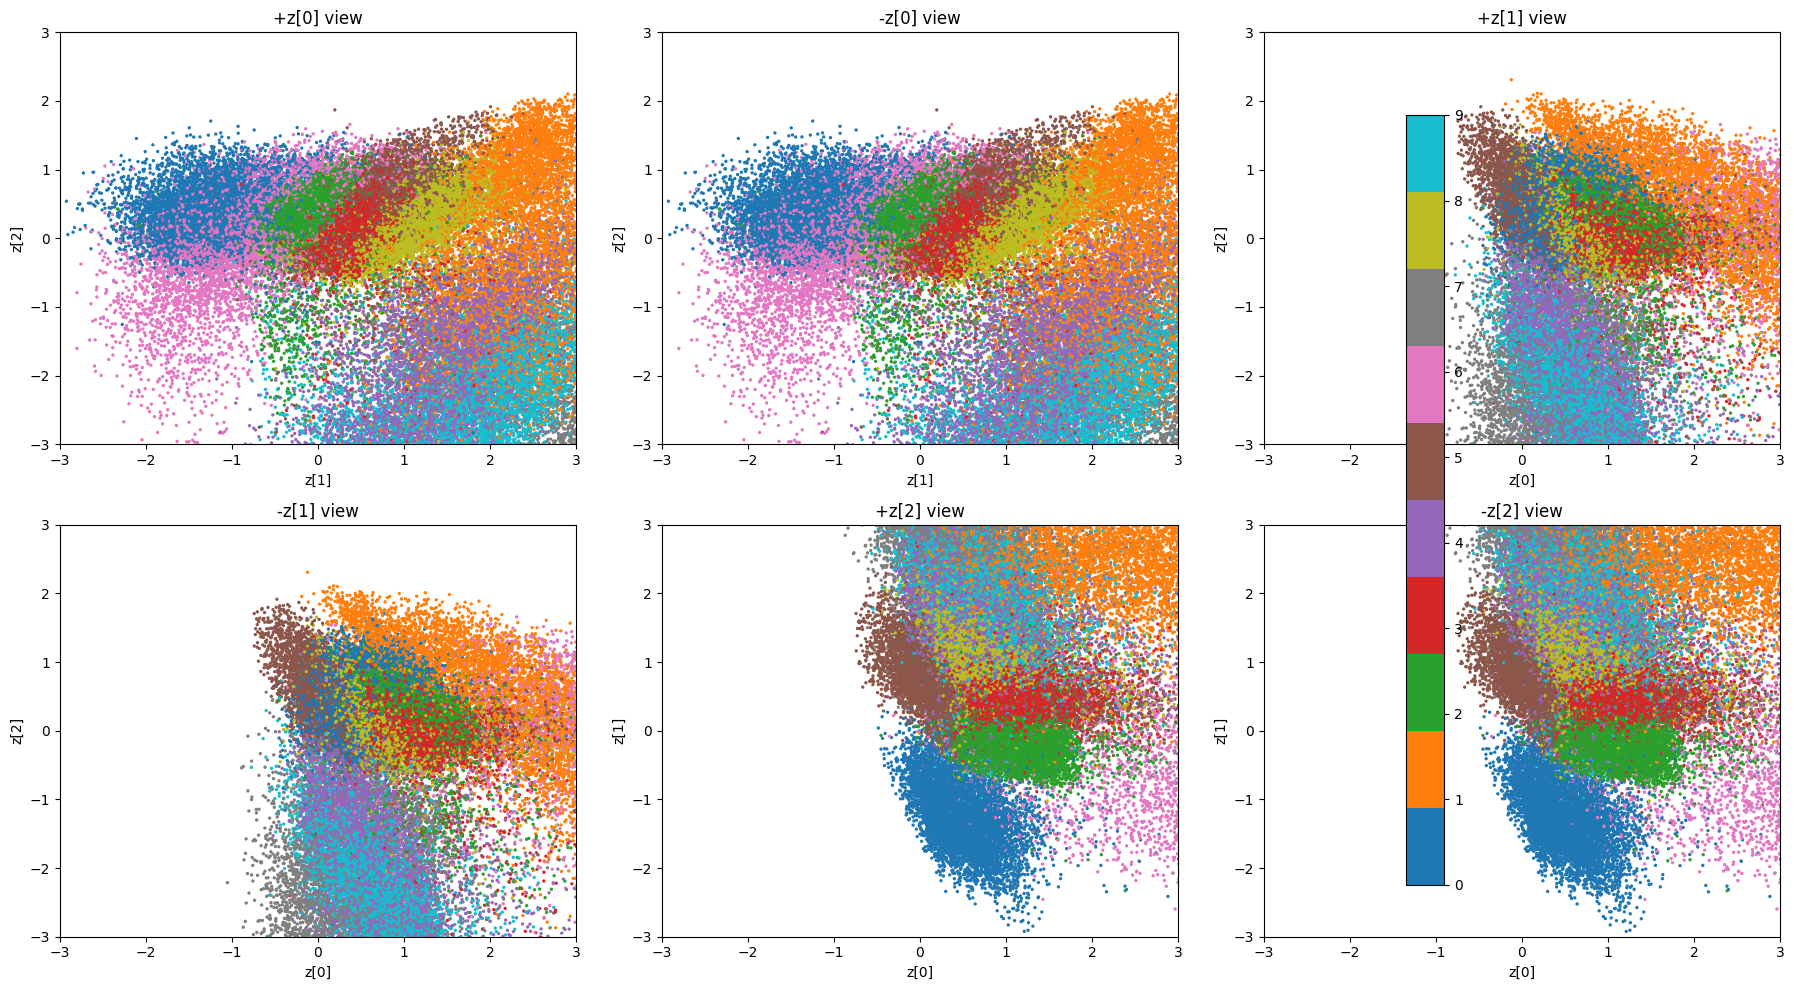

In [9]:
def plot_3d_latent_sides(x_train, labels, lim=3):
    z = ae.encoder.predict(x_train, verbose=0)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    plots = [
        (1, 2, "z[1]", "z[2]", "+z[0] view"),
        (1, 2, "z[1]", "z[2]", "-z[0] view"),

        (0, 2, "z[0]", "z[2]", "+z[1] view"),
        (0, 2, "z[0]", "z[2]", "-z[1] view"),

        (0, 1, "z[0]", "z[1]", "+z[2] view"),
        (0, 1, "z[0]", "z[1]", "-z[2] view"),
    ]

    for ax, (i, j, xl, yl, title) in zip(axes.flat, plots):
        sc = ax.scatter(
            z[:, i],
            z[:, j],
            c=labels,
            s=2,
            cmap="tab10"
        )
        ax.set_xlabel(xl)
        ax.set_ylabel(yl)
        ax.set_title(title)
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)

    fig.colorbar(sc, ax=axes.ravel().tolist())
    plt.tight_layout()
    plt.show()

plot_3d_latent_sides(mnist_digits, mnist_digit_labels)

Display a grid of sampled digits

In [10]:
def plot_latent_plane(decoder, fixed_dim, fixed_value, n=30, scale=1.5):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid[::-1]):
        for j, xi in enumerate(grid):

            z = np.zeros((1, 3))

            coords = [xi, yi]
            idx = 0

            for k in range(3):
                if k == fixed_dim:
                    z[0, k] = fixed_value
                else:
                    z[0, k] = coords[idx]
                    idx += 1

            x_decoded = decoder.predict(z, verbose=0)
            digit = x_decoded[0].reshape(28, 28)

            figure[
                i*digit_size:(i+1)*digit_size,
                j*digit_size:(j+1)*digit_size
            ] = digit

    plt.figure(figsize=(15, 15))
    plt.imshow(figure, cmap="gray")
    plt.title(f"z[{fixed_dim}] = {fixed_value}")
    plt.axis("off")
    plt.show()


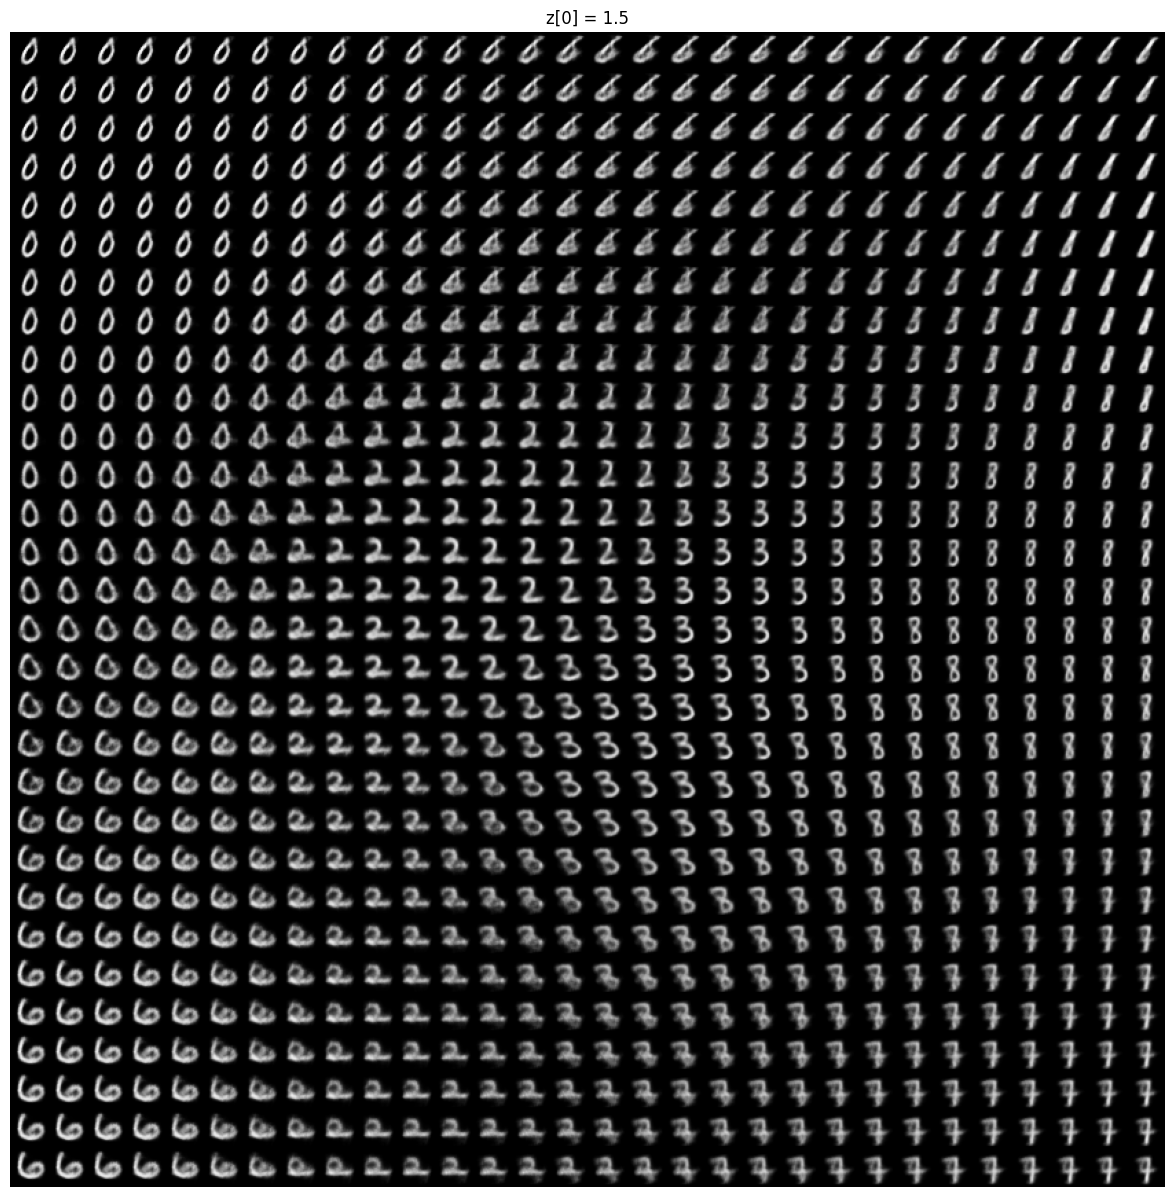

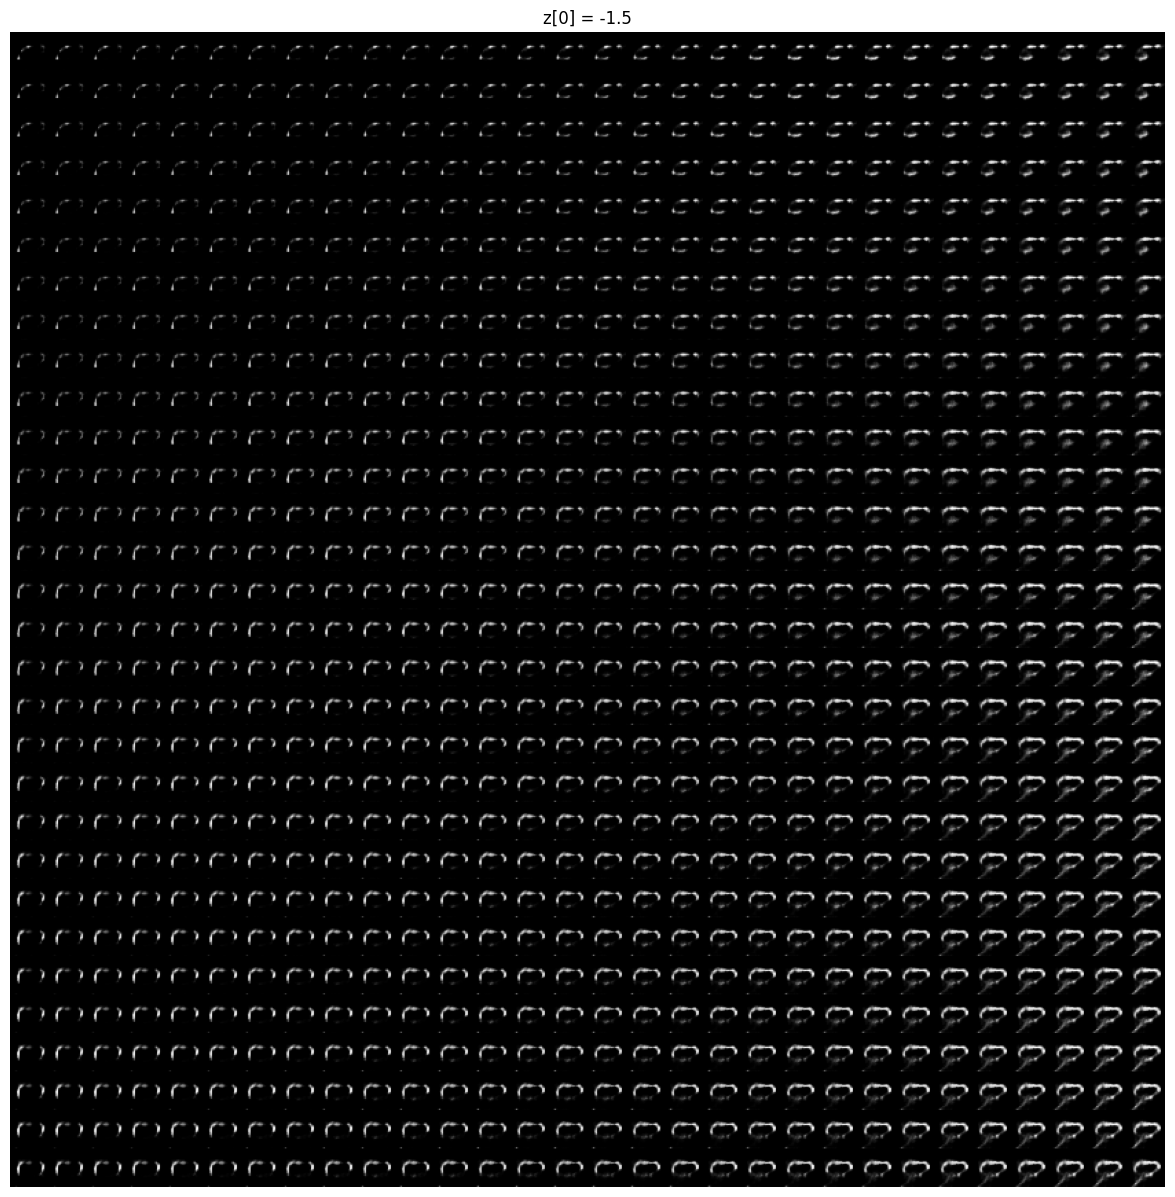

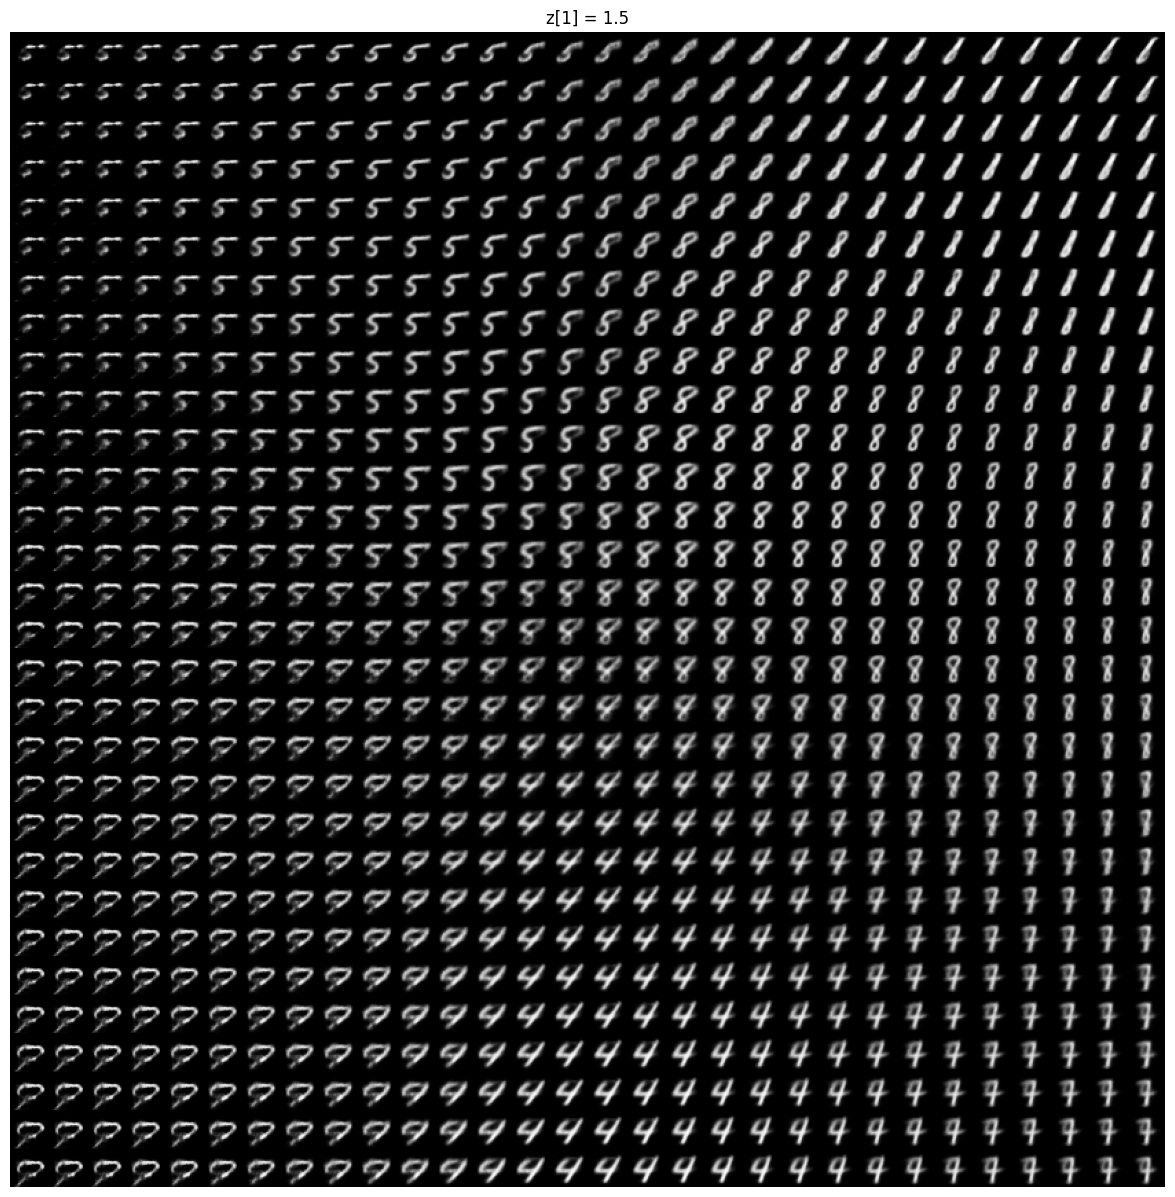

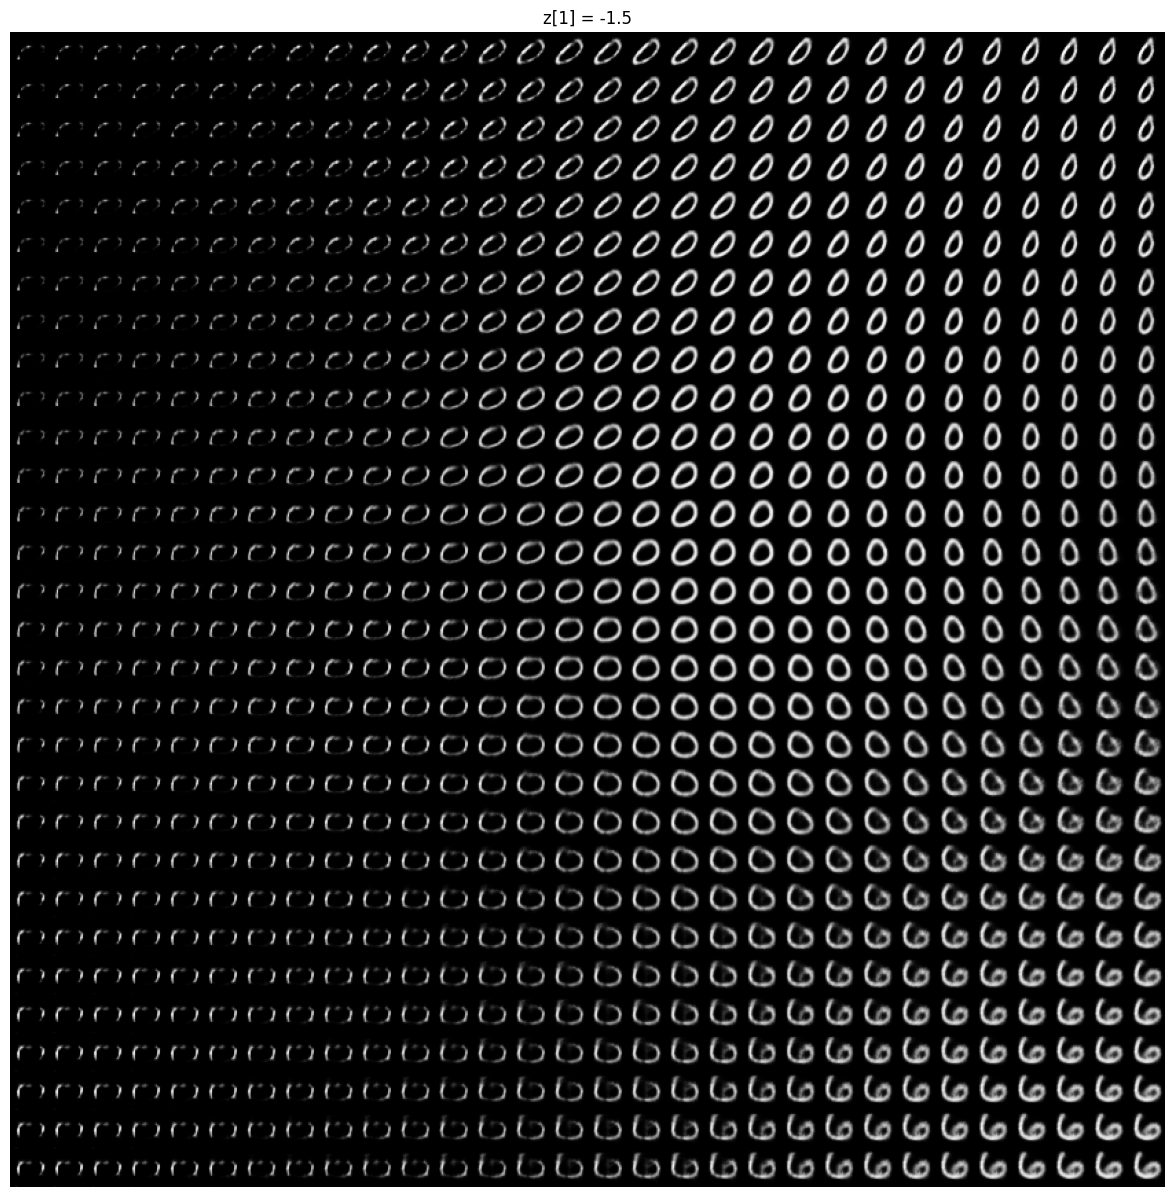

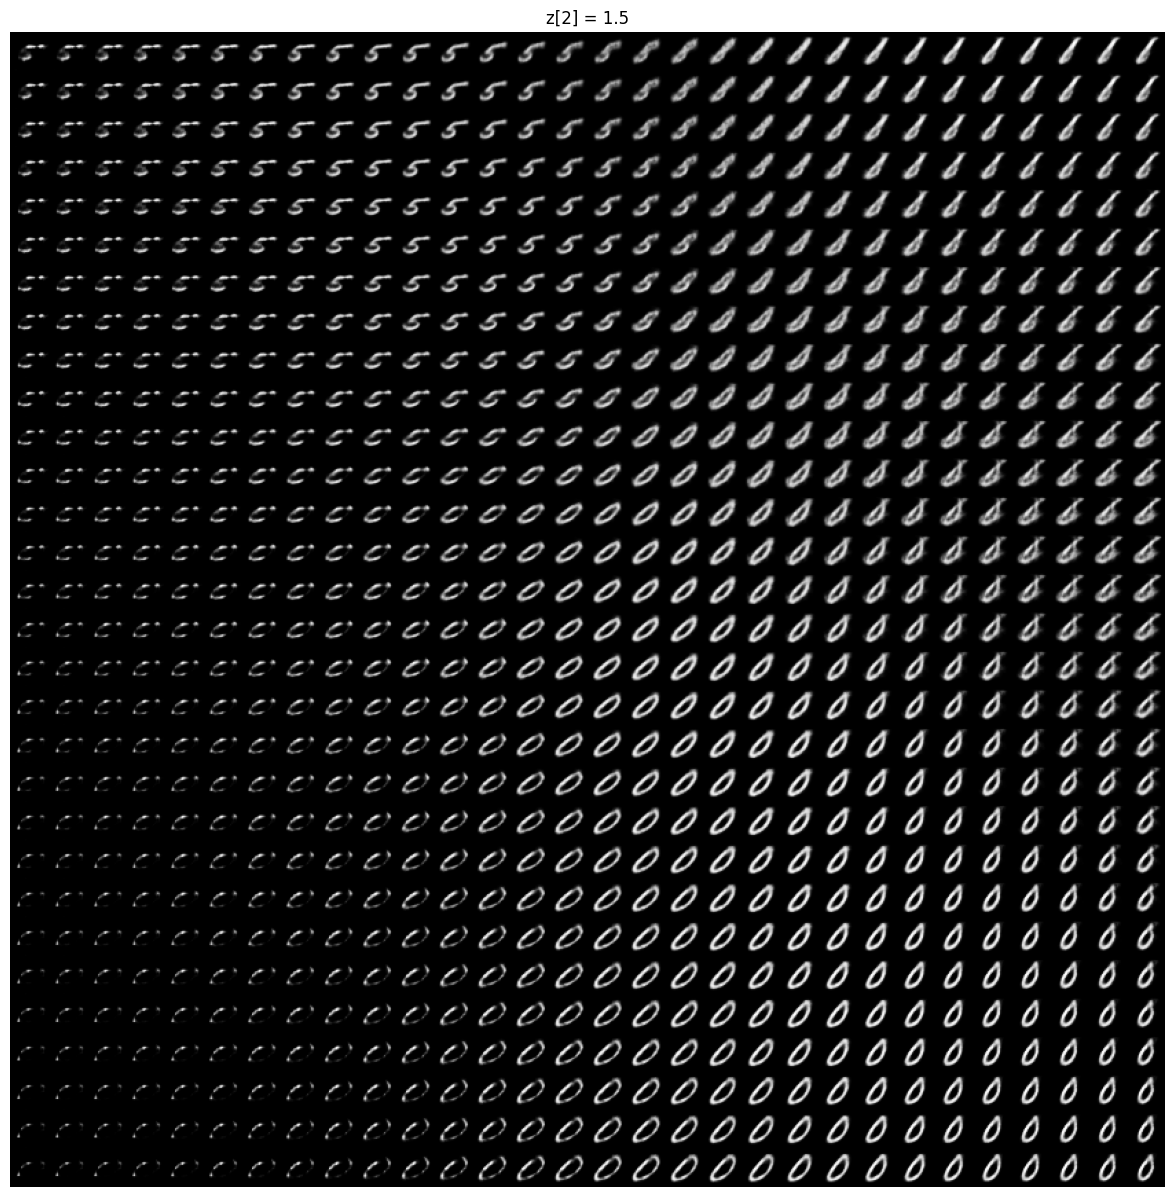

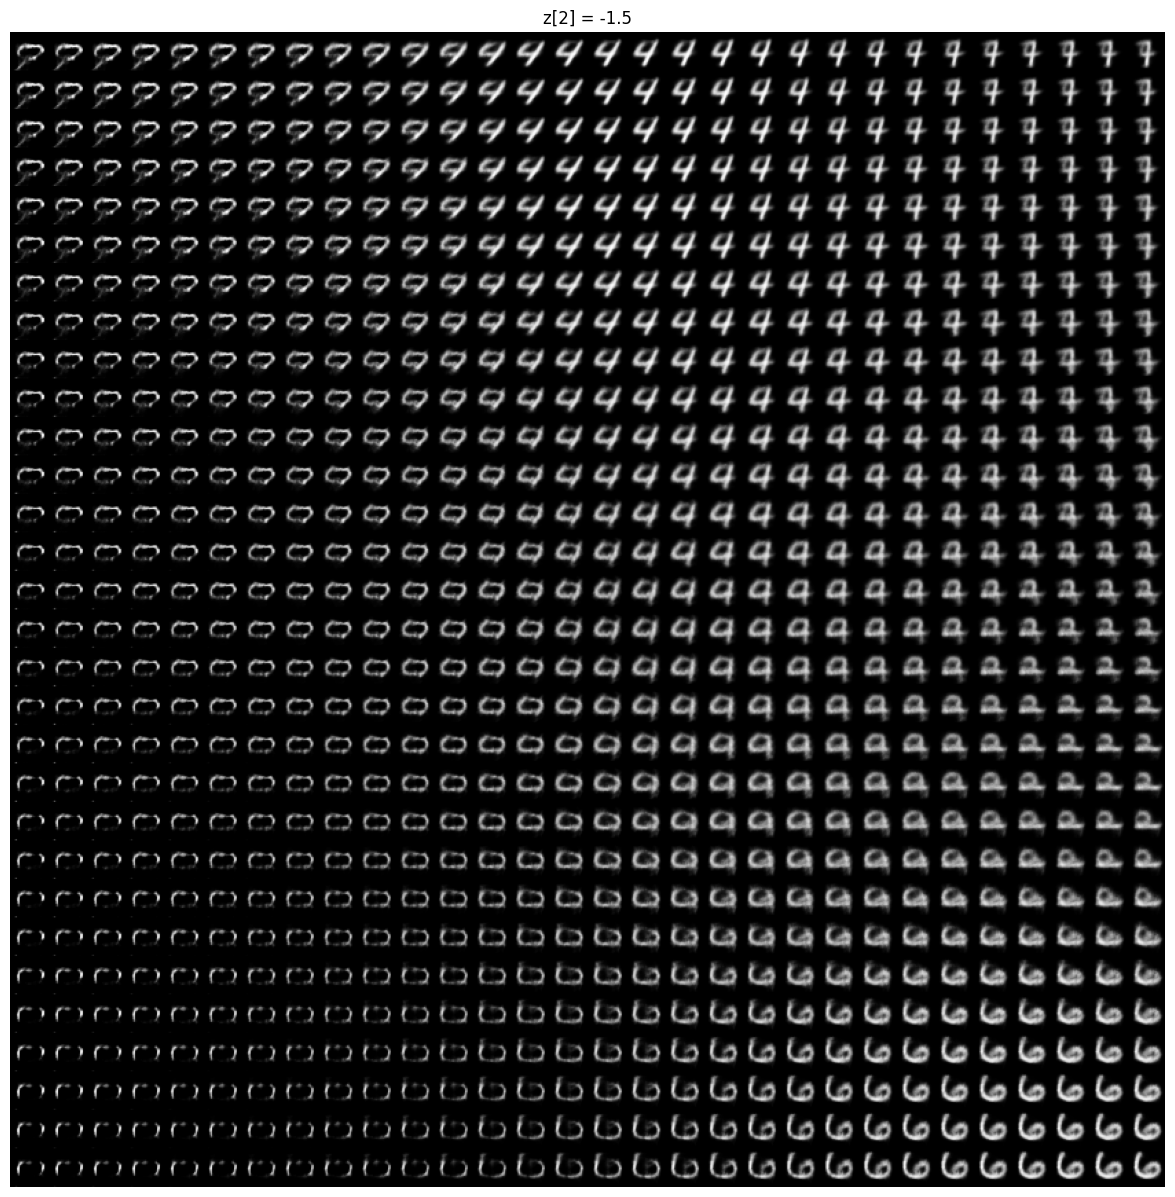

In [11]:
c = 1.5

plot_latent_plane(decoder, fixed_dim=0, fixed_value=+c)
plot_latent_plane(decoder, fixed_dim=0, fixed_value=-c)

plot_latent_plane(decoder, fixed_dim=1, fixed_value=+c)
plot_latent_plane(decoder, fixed_dim=1, fixed_value=-c)

plot_latent_plane(decoder, fixed_dim=2, fixed_value=+c)
plot_latent_plane(decoder, fixed_dim=2, fixed_value=-c)
